1. [Random number generator](#RNG)
2. [Simplistic model about a person's optimism / pessimism](#Model)
      1. [a) and b)](#Model-ab)
      2. [c)](#Model-c)

In [1]:
import random
import math
import numpy as np
import torch
import matplotlib.pyplot as plt

# Random number generator: GGL, RAN3, and Mersenne-Twister<a name="RMG"></a>
First of all, we implement the GGL generator, RAN3 generator whose seeds are generated by the GGL, and built-in random number generator in Python.

In [2]:
class LCG:
    """Linear congruential generators (LCG)"""
    def __init__(self, a=16807, b=0, m=math.pow(2, 31)-1):
        """x_{i+1} = (ax_i+b) mod m"""
        self.A = a
        self.B = b
        self.M = m
           
    def __call__(self, num_samples=500000, scale=True):
        """
        Return `num_samples` random floating point number.
        the sequence of random integers are distributed within 
        - [0, m-1] if self.B > 0 OR
        - [1, m-1] if self.B = 0
        
        Args:
        ----
        num_samples: int 
            number of random points to generate.
        scale: boolean
            whether to scale the generated points to (0, 1)
        """
        x = 0 if self.B > 0 else 1
        seq = [x]
        for _ in range(1, num_samples):
            x = (self.A * x + self.B) % self.M
            seq.append(x)
            
        if scale:
            seq = [elem/self.M for elem in seq]
        return seq

In [3]:
class LFG:
    """Lagged Fibonacci Generators (LFG)"""
    def __init__(self, r=55, s=24, m=math.pow(2, 32), ops='sub', seeds_generator=LCG()):
        """xi = (x_{i-r} ops x_{i-s}) mod m, where: 
        - r > s
        - ops is one of the following binary operations: add, sub, mul, xor"""
        if ops not in ['add', 'sub', 'mul', 'xor']: 
            raise ValueError('binary operations should be `add`, `sub`, `mul`, or `xor`.')
        if not r>s:
            raise ValueError('`r` should be larger than `s`')
            
        self.ops = ops
        self.r = r
        self.s = s
        self.m = m
        self.seeds = seeds_generator(r, scale=False)
        
    def __call__(self, num_samples=500000, scale=True):
        """
        Return `num_samples` random floating point number.
        Args:
        ----
        num_samples: int 
            number of random points to generate.
        scale: boolean
            whether to scale the generated points to (0, 1)
        """
        seq = self.seeds
        if self.ops == 'sub': 
            for idx in range(self.r, num_samples):
                x = (seq[idx-self.r] - seq[idx-self.s]) % self.m
                seq.append(x)
        else: 
            pass
        if scale:
            seq = [elem/self.m for elem in seq]
        return seq

In [4]:
class MT:
    """built-in random number generator in Python, Mersenne-Twister"""
    def __call__(self, num_samples=500000):
        seq = [random.random() for _ in range(num_samples)]
        return seq 

Then we generate random points with different random number generators, and inspect a small interval $x \in [1e-3, 1.5e-3]$ and $y \in [0, 1]$.

In [5]:
def coordinates(seq):
    """split random numbers into two sets `x` and `y` by odd and even indexs."""
    x = seq[::2]
    y = seq[1::2]
    return x, y

def plot(X, Y, a, b, axs=None, name=None):
    """ visualize points (x, y) whose x-value falls into a small interval (a, b).
    Args:
    -----
    X: list 
        x-coordinates
    Y: list
        y-coordinates
    a, b: float, float
        inspect x in interval (a, b)
    """
    if b < a:
        raise ValueError('`b` should be larger than `a`.')
    if not b-a<1e-3:
        raise ValueError('The interval `(a, b)` should be smaller than `1e-3`.')

    plot_x = list()
    plot_y = list()
    for idx, x in enumerate(X):
        if x >= a and x <= b:
            plot_x.append(x)
            plot_y.append(Y[idx])
    
    title = 'pseudo-random points'
    if name is not None:
        title += f', {name}'
    if axs is not None:
        axs.scatter(plot_x, plot_y)
        axs.set_title(title)
    else:
        plt.scatter(plot_x, plot_y)
        plt.set_title(title)

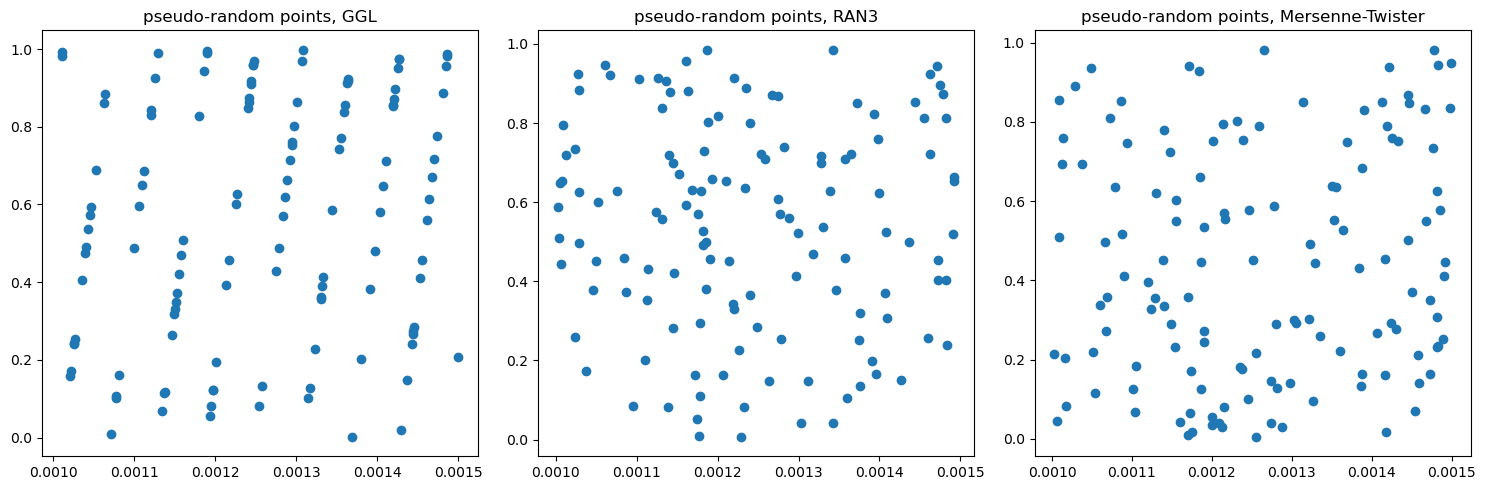

In [6]:
def plot_correlation(rng, num_samples=500000, a=1e-3, b=1.5e-3, axs=None):
    """generate `num_samples` random number in (0, 1) with random number generator `rng`, place the numbers as points,
    and visualize points in interval `(a, b)` on x-axis, (0, 1) on y-axis
    Args:
    -----
    rng: Tuple[name: str, object]
        the rng name and object.
    """
    name, rng_object = rng
    random_numbers = rng_object(num_samples)
    x, y = coordinates(random_numbers)
    plot(x, y, a, b, axs, name)
    
    
rngs = [('GGL', LCG()), 
        ('RAN3', LFG()), 
        ('Mersenne-Twister', MT())]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for idx, rng in enumerate(rngs):
    plot_correlation(rng, axs=axs[idx])
    
plt.tight_layout()

From the plottings, we can observe that points given by GGL order on parallel hyperplanes, illustrating the serious correlations between consecutive numbers $x_{i+1}, ..., x_{i+d}$ within one period (hyperplanes): In this case, we place these consecutive numbers as points in $(x, y)$-coordinates, then we have $y=x+16807/(2^{31}-1)$.

In contrast, points given by RAN3 and Mersenne-Twister generally show randomness and do not suffer from similar correlations.

# Simplistic model about a person's optimism / pessimism<a name="Model"></a>
First of all, we implement the stochastic models and the PMF plotting function.

In [7]:
def pmf(agents, log=False):
    """probability mass function given by histograms.
    Args: 
    ----
    log: boolean
        whether to use linear binning or logarithm binning.
    """
    N = len(agents)
    bins = [20, 35, 50]
    if log:
        bins = [np.logspace(start=np.log10(1), stop=np.log10(1000), num=nb) for nb in bins] # logarithmic binning
    
    fig, axs = plt.subplots(1, len(bins), figsize=(5*len(bins), 5))
    for idx, b in enumerate(bins):
        if log:
            axs[idx].set_xscale('log') # note: AND plot with logarithmic x-axis and linear y-axis!
        axs[idx].hist(agents, bins=b, density=True)
        #axs[idx].set_title(f'bins = {b}')
    
    suptitle = 'probability mass function using'
    suptitle = f'{suptitle} logarithmic binning' if log else  f'{suptitle} linear binning'
    fig.suptitle(suptitle)
    fig.tight_layout()
    
    return fig
    
def simulate(num_interaction, p_opt,shift_opt, shift_pes, additive=True, log=False):    
    """state changing with interactions.
    Args:
    ----
    num_interactions: int 
        number of interactions for each agents.
    p_opt: float
        probability towards optimism
    shift_opt: float 
        each new interaction can shift the state towards optimism by `shift_opt`
    shift_pes: float 
        each new_interaction can shift the state towards pessimism by `shift_pes`
    """
    num_agents, init_state = 500000, 50.0 # number of agents and their initial states.
    agents = np.ones((num_agents))* init_state
    interactions = np.random.choice([shift_opt, shift_pes], size=(num_agents, num_interaction), p=[p_opt, 1-p_opt]) # each interaction are indepedent
    if additive:
        shift = interactions.sum(axis=1)
        agents += shift
    else:
        shift = np.multiply.reduce(interactions, 1)
        agents *= shift
        
    pmf(agents, log) # plot pmf function

## a)  and b)<a name="Model-ab"></a>
The plottings of PMF for a) and b) are shown below. Both of the PMF show normal-like shape. 

We know the shifts from interactions are independent and identically distributed - more specifically, having the same probability of having a certain value. An agent's final state will be the sum of interaction shifts and the inital state value:
$$
S_{i} = S_0 + f(S_1) + ... + f(S_{i-1}) = 50 + f(S_1) + ... + f(S_{i-1})
$$
where $f$ is the agent response function on the given state.

1. Probability mass function (PMF): the PMF will be a binomial distrubtion centered at 50.

2. Probability density function (PDF): by the central limit theorem, the PDF will be a normal distribution centered at 50.
   

PMF using linear binning for a) is shown below; 3 different bin widths are used.


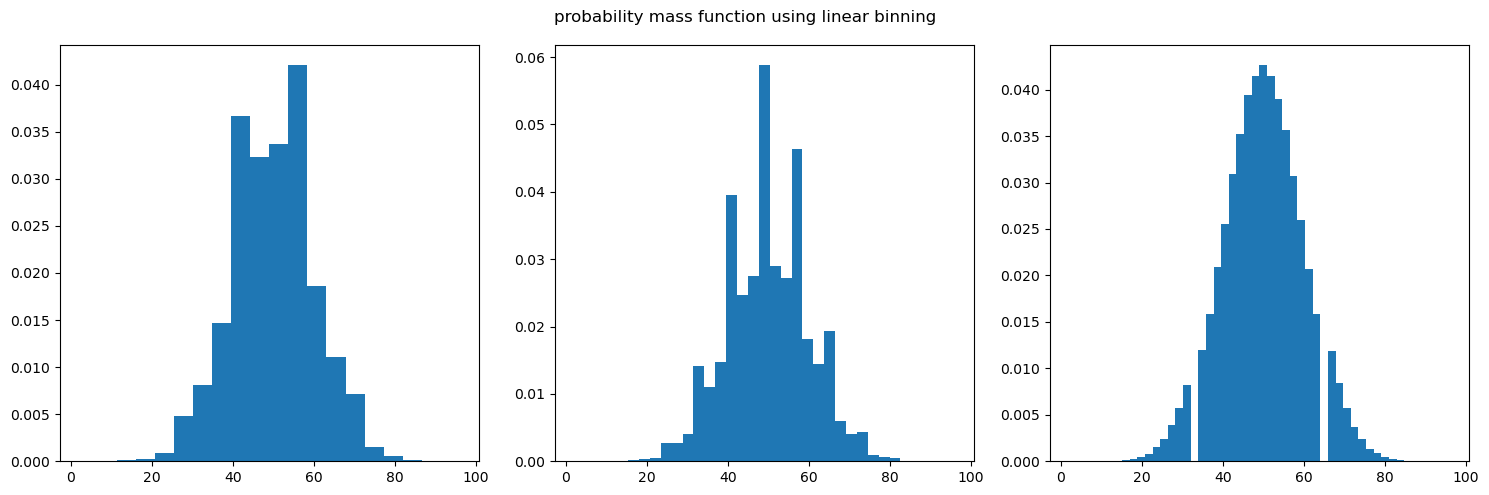

In [8]:
print('PMF using linear binning for a) is shown below; 3 different bin widths are used.')
num_interaction = 100
p_opt = 0.5
shift_opt, shift_pes = 1, -1
fig_a = simulate(num_interaction, p_opt, shift_opt, shift_pes)

PMF using linear binning for b) is shown below; 3 different bin widths are used.


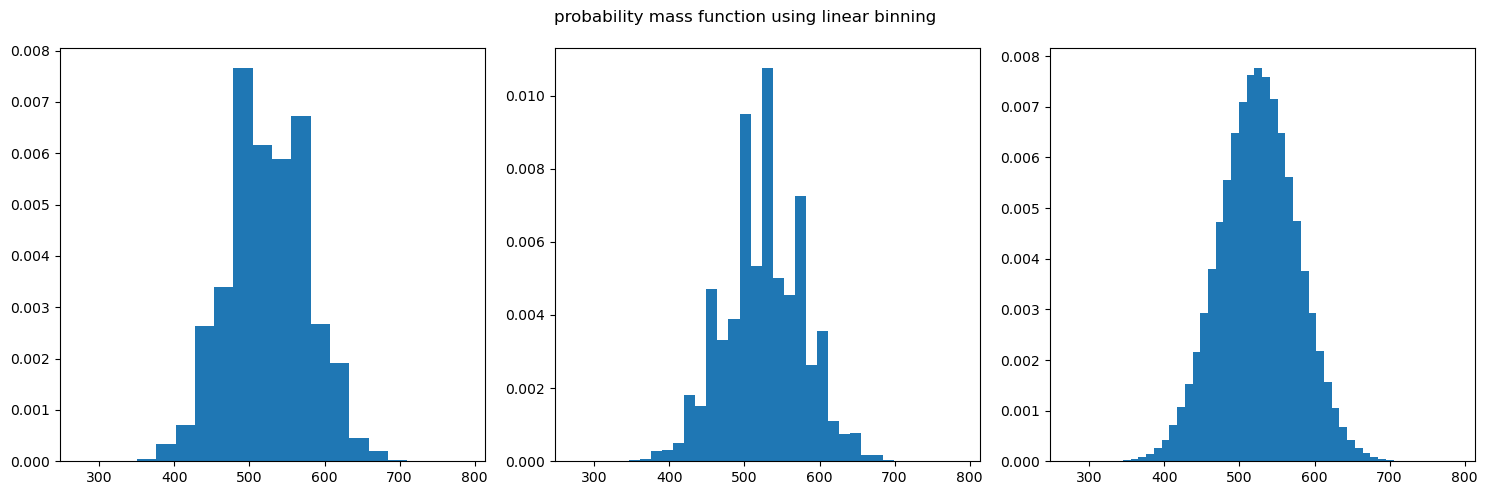

In [9]:
print('PMF using linear binning for b) is shown below; 3 different bin widths are used.')
shift_opt, shift_pes = 10, -0.5
fig_b = simulate(num_interaction, p_opt, shift_opt, shift_pes)

## c)<a name="Model-c"></a>
The plottings of PMF using linear binning and logarithm binning for c) are shown below. With linear binning, we see a skewed distribution; while a normal-like distribution can be observed when using logarithmic binning and logarithmic x-axis. 

We know the shifts from interactions are still independent and identically distributed, while a multiplicative process is used here rather than the additive process used in a) and b). An agent's final state will be the multiplication of interaction shifts and the inital state value:
$$
S_{i} = S_0*f(S_1) * ... * f(S_{i-1}) = 50 * f(S_1) * ... * f(S_{i-1})
$$

- The stochastic process is multiplicatively stochastic processes.
- By the logarithmic central-limit theorem, The asymptotic PDF is a log-normal distribution.

*Note that to determine log-normal distribution, we need to both use logarithmic binning and logarithmic x-axis, with linear y-axis.*

PMF using linear binning for c) is shown below; 3 different bin widths are used.


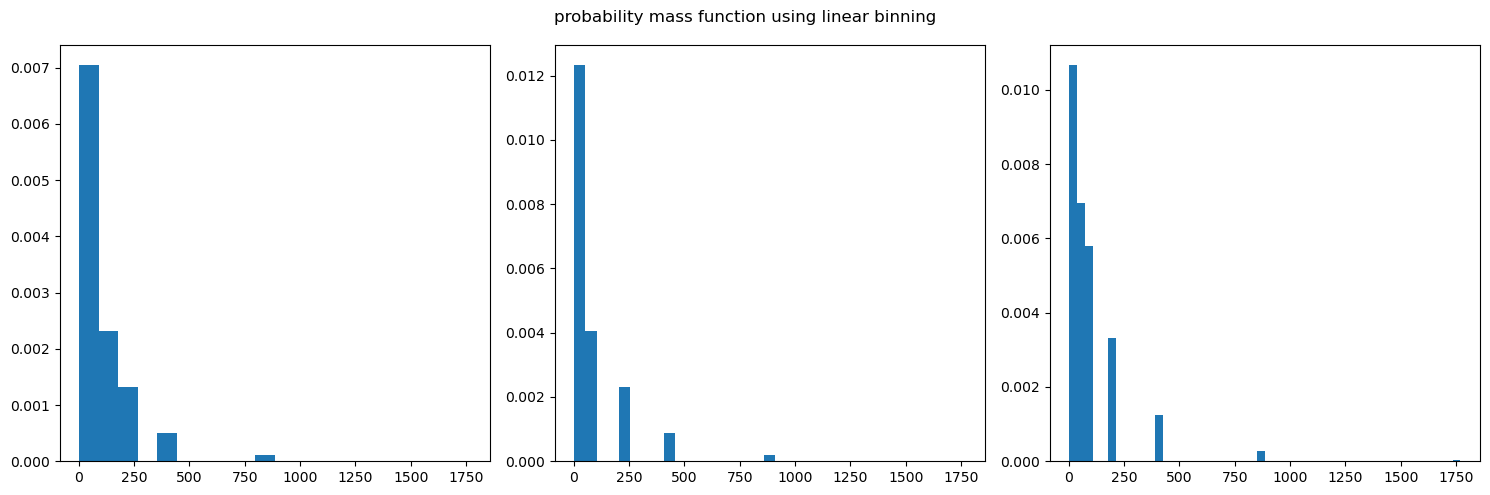

In [10]:
print('PMF using linear binning for c) is shown below; 3 different bin widths are used.')
num_interaction = 10
shift_opt, shift_pes = 1/0.7, 0.7
fig_linear = simulate(num_interaction, p_opt, shift_opt, shift_pes, additive=False)

PMF using logarithmic binning for c) is shown below; 3 different bin widths are used.


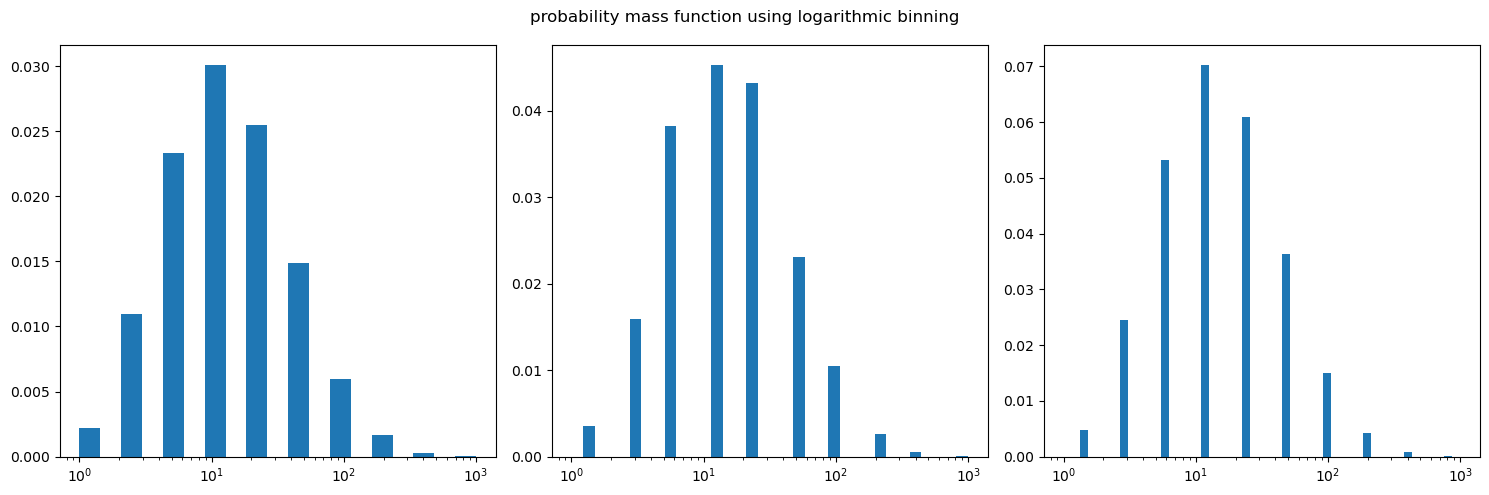

In [12]:
print('PMF using logarithmic binning for c) is shown below; 3 different bin widths are used.')
fig_log = simulate(num_interaction, p_opt, shift_opt, shift_pes, additive=False, log=True)